### Preprocessing an audio dataset

Loading a dataset with 🤗 Datasets is just half of the fun. If you plan to use it either for training a model, or for running inference, you will need to pre-process the data first. In general, this will involve the following steps:

- Resampling the audio data
- Filtering the dataset
- Converting audio data to model’s expected input

#### Resampling the audio data

The load_dataset function downloads audio examples with the sampling rate that they were published with. This is not always the sampling rate expected by a model you plan to train, or use for inference. If there’s a discrepancy between the sampling rates, you can resample the audio to the model’s expected sampling rate.

In [10]:
from datasets import Audio, load_dataset

# load dataset
minds = load_dataset("PolyAI/minds14", name="en-AU", split="train", trust_remote_code=True)

Most of the available pretrained models have been pretrained on audio datasets at a sampling rate of 16 kHz. When we explored MINDS-14 dataset, you may have noticed that it is sampled at 8 kHz, which means we will likely need to upsample it.

To do so, use 🤗 Datasets’ cast_column method. This operation does not change the audio in-place, but rather signals to datasets to resample the audio examples on the fly when they are loaded. 

The following code will set the sampling rate to 16kHz:

In [11]:
# set sampling rate to 16KHz
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

Re-load the first audio example in the MINDS-14 dataset, and check that it has been resampled to the desired sampling rate:

In [12]:
minds[0]

{'path': '/home/rlimonta/.cache/huggingface/datasets/downloads/extracted/7c73797e399dc940facc5dedb2e9a9e893a1de9d628b685a0d58c032d38c9897/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/rlimonta/.cache/huggingface/datasets/downloads/extracted/7c73797e399dc940facc5dedb2e9a9e893a1de9d628b685a0d58c032d38c9897/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

### Filtering the dataset

You may need to filter the data based on some criteria. One of the common cases involves limiting the audio examples to a certain duration. For instance, we might want to filter out any examples longer than 20s to prevent out-of-memory errors when training a model.

We can do this by using the 🤗 Datasets’ filter method and passing a function with filtering logic to it. Let’s start by writing a function that indicates which examples to keep and which to discard. This function, is_audio_length_in_range, returns True if a sample is shorter than 20s, and False if it is longer than 20s.

You may notice that the array values are now also different. This is because we’ve now got twice the number of amplitude values for every one that we had before.

In [13]:
MAX_DURATION_IN_SECONDS = 20.0

def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

The filtering function can be applied to a dataset’s column but we do not have a column with audio track duration in this dataset. However, we can create one, filter based on the values in that column, and then remove it.

In [14]:
import librosa

# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 624
})

We can verify that dataset has been filtered down from 654 examples to 624.

### Pre-processing audio data

One of the most challenging aspects of working with audio datasets is preparing the data in the right format for model training. As you saw, the raw audio data comes as an array of sample values. However, pre-trained models, whether you use them for inference, or want to fine-tune them for your task, expect the raw data to be converted into input features. The requirements for the input features may vary from one model to another — they depend on the model’s architecture, and the data it was pre-trained with. The good news is, for every supported audio model, 🤗 Transformers offer a feature extractor class that can convert raw audio data into the input features the model expects.

So what does a feature extractor do with the raw audio data? Let’s take a look at Whisper’s feature extractor to understand some common feature extraction transformations. Whisper is a pre-trained model for automatic speech recognition (ASR) published in September 2022 by Alec Radford et al. from OpenAI.

First, the Whisper feature extractor pads/truncates a batch of audio examples such that all examples have an input length of 30s. Examples shorter than this are padded to 30s by appending zeros to the end of the sequence (zeros in an audio signal correspond to no signal or silence). Examples longer than 30s are truncated to 30s. Since all elements in the batch are padded/truncated to a maximum length in the input space, there is no need for an attention mask. Whisper is unique in this regard, most other audio models require an attention mask that details where sequences have been padded, and thus where they should be ignored in the self-attention mechanism. Whisper is trained to operate without an attention mask and infer directly from the speech signals where to ignore the inputs.

The second operation that the Whisper feature extractor performs is converting the padded audio arrays to log-mel spectrograms. As you recall, these spectrograms describe how the frequencies of a signal change over time, expressed on the mel scale and measured in decibels (the log part) to make the frequencies and amplitudes more representative of human hearing.

All these transformations can be applied to your raw audio data with a couple of lines of code. Let’s go ahead and load the feature extractor from the pre-trained Whisper checkpoint to have ready for our audio data:

In [16]:
from transformers import WhisperFeatureExtractor
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Next, you can write a function to pre-process a single audio example by passing it through the feature_extractor.

In [18]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

We can apply the data preparation function to all of our training examples using 🤗 Datasets’ map method:

In [37]:
minds = minds.map(prepare_dataset)

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

In [38]:
#Audio dataset features extracted
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_features'],
    num_rows: 624
})

In [39]:
# audio attributes
audio = minds[0]['audio']

print("---------------------")
print("Audio Array")
print("---------------------")
print(audio['array'])
print("\n")
print("---------------------")
print("Audio Sampling Rate")
print("---------------------")
print(audio['sampling_rate'])

---------------------
Audio Array
---------------------
[0.         0.00018311 0.00021362 ... 0.00091553 0.00115967 0.0007019 ]


---------------------
Audio Sampling Rate
---------------------
16000


As easy as that, we now have log-mel spectrograms as input_features in the dataset.

Let’s visualize it for one of the examples in the minds dataset:

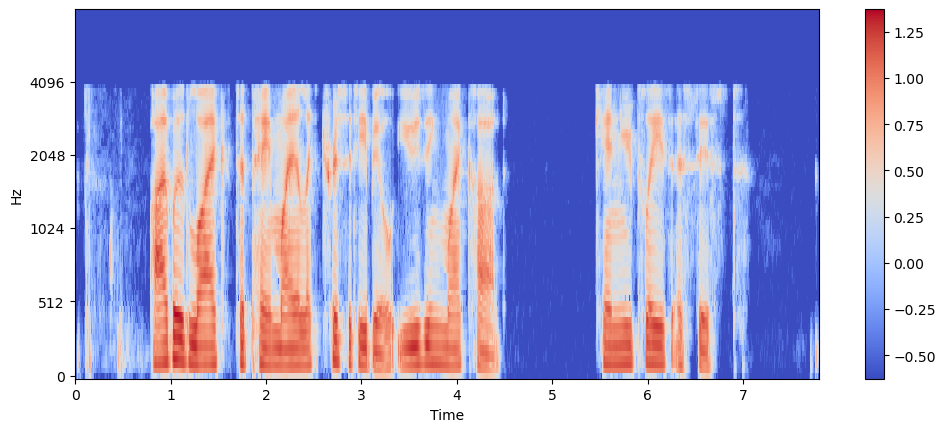

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

Now you can see what the audio input to the Whisper model looks like after preprocessing.

The model’s feature extractor class takes care of transforming raw audio data to the format that the model expects. However, many tasks involving audio are multimodal, e.g. speech recognition. In such cases 🤗 Transformers also offer model-specific tokenizers to process the text inputs. For a deep dive into tokenizers, please refer to our NLP course.

You can load the feature extractor and tokenizer for Whisper and other multimodal models separately, or you can load both via a so-called processor. To make things even simpler, use AutoProcessor to load a model’s feature extractor and processor from a checkpoint, like this:

In [41]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("openai/whisper-small")

Here we have illustrated the fundamental data preparation steps. Of course, custom data may require more complex preprocessing. In this case, you can extend the function prepare_dataset to perform any sort of custom data transformations. With 🤗 Datasets, if you can write it as a Python function, you can apply it to your dataset!